# Junction Naming

__December 2022__

Can we find an automatic way of naming junctions?

In [41]:
import sys
import importlib
import osmnx as ox

sys.path.append("../src/")
f = importlib.import_module('03-build-junctions-graph')

# this prevents a lot of future warnings that are coming out of oxmnx
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Nodes: 648


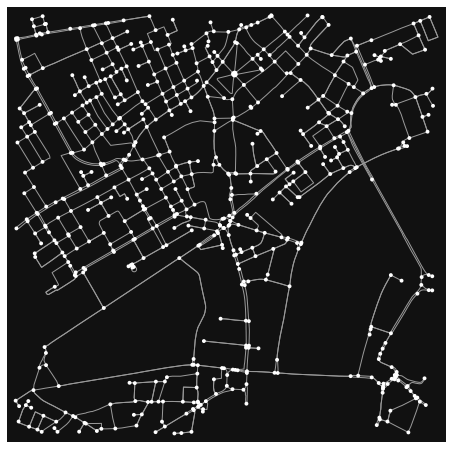

In [2]:
G1 = ox.graph_from_address(
    'London, UK',
    network_type='drive',
    dist=1000
)

print(f'Nodes: {len(G1.nodes)}')
ox.plot_graph(G1);

Nodes: 228


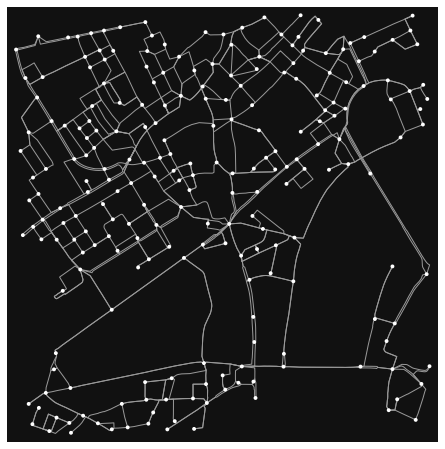

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [3]:
G2 = ox.consolidate_intersections(
    ox.project_graph(G1),
    tolerance=25,  # combines junctions within 25m
    rebuild_graph=True,
    dead_ends=False,
    reconnect_edges=True
)

print(f'Nodes: {len(G2.nodes)}')
ox.plot_graph(G2)

In [69]:
def combine_names(names):
    names = names.dropna().values
    flat_names = []
    for n in names:
        if type(n) == list:
            for m in n:
                flat_names.append(m)
        else:
            flat_names.append(n)
    
    unique_names = list(set(flat_names))
    print(unique_names)

#     name = '-'.join(unique_names)
    return unique_names

In [65]:
# create datafraems from G1 & G2
df_lower = (
    ox.graph_to_gdfs(
        G1,
        nodes=True,
        edges=False,
        node_geometry=True,
        fill_edge_geometry=False
    )
    .drop(columns=['highway', 'street_count'])
    .reset_index()
    .rename(columns={'y': 'lat', 'x': 'lon', 'osmid': 'osmid_original'})
)

df_higher = ox.graph_to_gdfs(
    G2,
    nodes=True,
    edges=False,
    node_geometry=True,
    fill_edge_geometry=False
)

df_higher['osmid_original'] = df_higher['osmid_original'].apply(f.convert_strings_list)
df_higher = df_higher.explode('osmid_original')
df_higher['osmid_original'] = df_higher['osmid_original'].astype(int)

df_higher = (
    df_higher
    .reset_index()
    .drop(columns=['x', 'y', 'street_count', 'highway', 'lon', 'lat'])
    .rename(columns={'osmid': 'osmid_cluster'})
)

# Combine datasets
df = df_lower.merge(
    df_higher,
    how='left',
    on='osmid_original',
    suffixes=['_original', '_cluster']
)

df.head()

,osmid_original,lat,lon,geometry_original,osmid_cluster,geometry_cluster
0,107322,51.516246,-0.132866,POINT (-0.13287 51.51625),0.0,POINT (698926.154 5711133.518)
1,107324,51.515647,-0.132440,POINT (-0.13244 51.51565),2.0,POINT (698958.339 5711068.035)
2,107326,51.515137,-0.132766,POINT (-0.13277 51.51514),4.0,POINT (698935.419 5710992.587)
3,107328,51.514820,-0.132309,POINT (-0.13231 51.51482),4.0,POINT (698935.419 5710992.587)
4,107333,51.515305,-0.141966,POINT (-0.14197 51.51531),6.0,POINT (698296.168 5710999.886)


In [70]:
edges_df = (
    ox
    .graph_to_gdfs(G1, nodes=False)
    .reset_index()
)

edges_df['junction_name'] = (
    edges_df
    .groupby('u')
    ['name']
    .transform(combine_names)
)

# edges_df

['Oxford Street']
['Soho Street', 'Soho Square']
['Soho Square']
['Soho Square', 'Frith Street']
['Oxford Street', 'Regent Street']
['Strand', 'Aldwych', 'Arundel Street']


ValueError: Length of values (3) does not match length of index (4)

In [ ]:
junction_names = (
    edges_df[['u', 'junction_name']]
    .rename(columns={'u': 'osmid_original'})
    .drop_duplicates()
)

df = df.merge(
    junction_names,
    how='left',
    on='osmid_original'
)

df['cluster_name'] = (
    df
    .groupby('osmid_cluster')
    ['junction_name']
    .transform(combine_names)
)

df

In [ ]:
df1['junction_name'].unique()